Класификация текстов с помощью различных методов векторизации слов

In [1]:
import json
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython import display
from nltk.tokenize import WordPunctTokenizer
from sklearn import naive_bayes
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

%matplotlib inline

out_dict= dict()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

предобработка и токенизация

In [2]:
df = pd.read_csv(
    "https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv",
    delimiter="\t",
    header=None,
)
texts_train=df[0].values[:5000]
y_train=df[1].values[:5000]
texts_test=df[0].values[5000:]
y_test=df[1].values[5000:]

tokenizer = WordPunctTokenizer()
preprocess = lambda text: " ".join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print(
    "before:",
    text,
)
print(
    "after:",
    preprocess(text),
)
texts_train = [preprocess(text) for text in texts_train]
texts_test = [preprocess(text) for text in texts_test]

assert (
    texts_train[5]
    == "campanella gets the tone just right funny in the middle of sad in the middle of hopeful"
)
assert texts_test[74] == "poetry in motion captured on film"
assert len(texts_test) == len(y_test)


before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown - up at work : replace " i don ' t want to do that " with " ok , great !".


In [3]:
def plot_train_process(
    train_loss, val_loss, train_accuracy, val_accuracy, title_suffix=""
):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title(" ".join(["Loss", title_suffix]))
    axes[0].plot(train_loss, label="train")
    axes[0].plot(val_loss, label="validation")
    axes[0].legend()

    axes[1].set_title(" ".join(["Validation accuracy", title_suffix]))
    axes[1].plot(train_accuracy, label="train")
    axes[1].plot(val_accuracy, label="validation")
    axes[1].legend()
    plt.show()

def visualize_and_save_results(
      model, model_name, X_train, X_test, y_train, y_test, out_dict
  ):
    for data_name, X, y, model in [
        ("train", X_train, y_train, model),
        ("test", X_test, y_test, model),
    ]:
      if isinstance(model, BaseEstimator):
        proba = model.predict_proba(X)[:, 1]
      elif isinstance(model, nn.Module):
        proba = model(X).detach().cpu().numpy()[:, 1]
      else:
        raise ValueError("Unrecognized model type")

      auc = roc_auc_score(y, proba)

      out_dict[f"{model_name}_{data_name}"]=auc
      plt.plot(*roc_curve(y,proba)[:2], label="{} AUC={:.4f}".format(data_name, auc))

    plt.plot(
        [0,1],
        [0,1],
        "--",
        color="black"
    )
    plt.legend(fontsize='large')
    plt.title(model_name)
    plt.grid()
    return out_dict

Bag of words


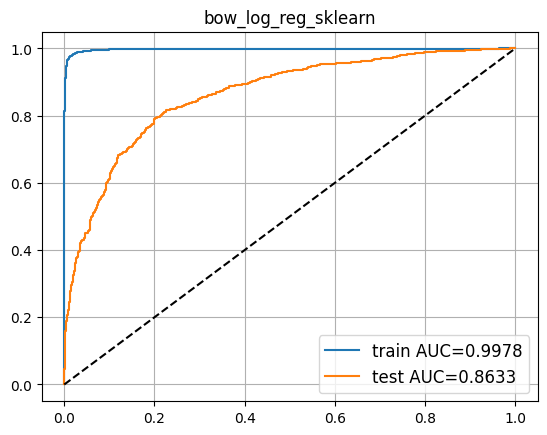

In [4]:
k=min(10000, len(set(" ".join(texts_train).split())))

counts = Counter(" ".join(texts_train).split())

bow_vocabulary = [key for key,val in counts.most_common(k)]

def text_to_bow(text):
    """convert text string to an array of token counts. Use bow_vocabulary."""
    sent_vec =np.zeros(len(bow_vocabulary))
    counts = Counter(text.split())
    for i, token in enumerate(bow_vocabulary):
      if token in counts:
        sent_vec[i] = counts[token]

    return np.array(sent_vec, "float32")

X_train_bow=np.stack(list(map(text_to_bow, texts_train)))
X_test_bow=np.stack(list(map(text_to_bow,texts_test)))

k_max=len(set(" ".join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(
    X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in texts_train[5:10]])
)
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[65, bow_vocabulary.index("!")] == texts_train[65].split().count("!")

bow_model = LogisticRegression(max_iter=1500).fit(X_train_bow, y_train)

out_dict = visualize_and_save_results(
    bow_model, "bow_log_reg_sklearn", X_train_bow, X_test_bow, y_train, y_test, out_dict
)


Теперь напишем сами

In [5]:
X_train_bow.shape

(5000, 10000)

In [6]:
class my_bow_model(nn.Module):
  def __init__(self, vector_size=k, h_l=32):
    super(my_bow_model,self).__init__()
    self.fc1=nn.Linear(vector_size, h_l)
    self.fc2=nn.Linear(h_l,2)
    self.relu=nn.ReLU()

  def forward(self,x):
    return self.fc2(self.relu(self.fc1(x)))

In [7]:
model=my_bow_model(10000)

In [8]:
loss_function = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
X_train_bow_torch = torch.tensor(X_train_bow,dtype=torch.float32).to(device)
X_test_bow_torch = torch.tensor(X_test_bow,dtype=torch.float32).to(device)

y_train_torch = torch.tensor(y_train,dtype=torch.long).to(device)
y_test_torch = torch.tensor(y_test,dtype=torch.long).to(device)

In [10]:
def train_model(
    model,
    opt,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=500,
    show_plots=True,
    eval_every=50
):
  train_loss_history = []
  train_acc_history = []
  val_loss_history = []
  val_acc_history = []

  local_train_loss_history = []
  local_train_acc_history = []
  for i in range(n_iterations):

      ix = np.random.randint(0,len(X_train_torch), batch_size)
      x_batch = X_train_torch[ix]
      y_batch = y_train_torch[ix]

      y_predicted=model(x_batch)

      loss=loss_function(y_predicted,y_batch)

      loss.backward()
      opt.step()
      opt.zero_grad()

      local_train_loss_history.append(loss.item())
      local_train_acc_history.append(
          accuracy_score(
              y_batch.to('cpu').detach().numpy(),
              y_predicted.to('cpu').detach().numpy().argmax(axis=1)
          )
      )
      if i % eval_every == 0:
          train_loss_history.append(np.mean(local_train_loss_history))
          train_acc_history.append(np.mean(local_train_acc_history))
          local_train_loss_history, local_train_acc_history = [], []

          predictions_val = model(X_val_torch)
          val_loss_history.append(loss_function(predictions_val, y_val_torch).item())

          acc_score_val = accuracy_score(y_val_torch.cpu().detach().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
          val_acc_history.append(acc_score_val)
          if show_plots:

              display.clear_output(wait=True)
              plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
  return model


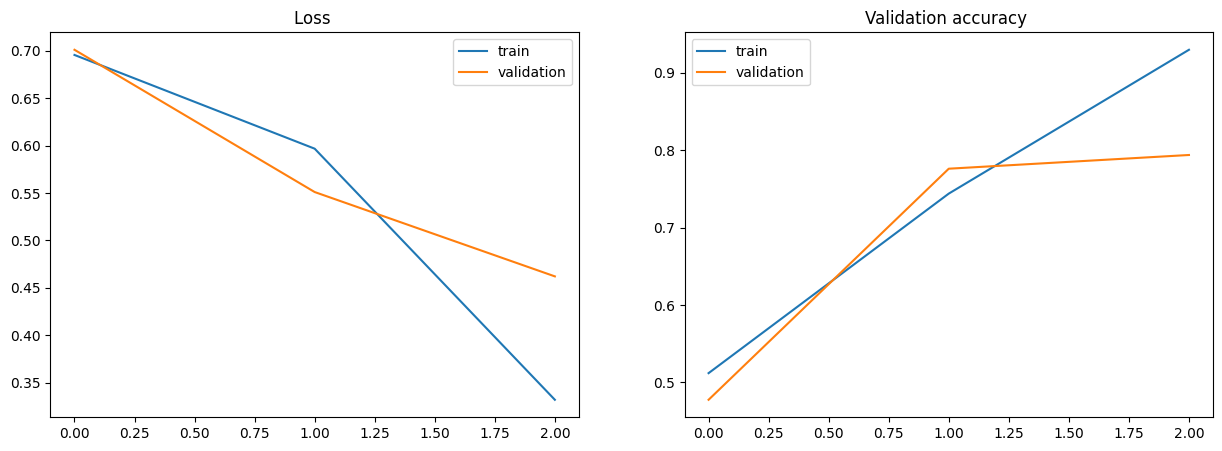

In [11]:
bow_nn_model = train_model(
    model,
    opt,
    X_train_bow_torch,
    y_train_torch,
    X_test_bow_torch,
    y_test_torch,
    n_iterations=101,
    # show_plots=False
)

0.8636402678551043 0.8632912603519866


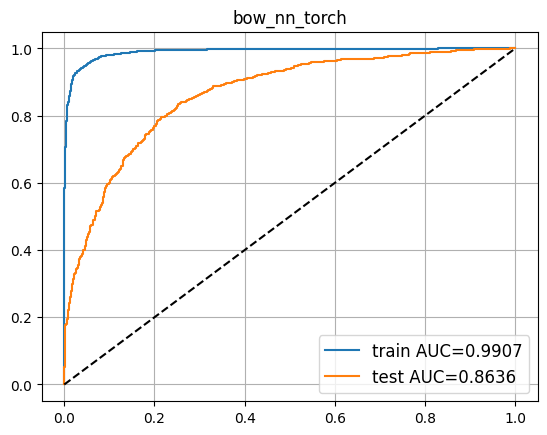

In [12]:

# do not change the code in the block below
# __________start of block__________
out_dict = visualize_and_save_results(
    bow_nn_model,
    "bow_nn_torch",
    X_train_bow_torch,
    X_test_bow_torch,
    y_train,
    y_test,
    out_dict,

)
print(out_dict["bow_nn_torch_test"],out_dict["bow_log_reg_sklearn_test"])
assert (
    out_dict["bow_log_reg_sklearn_test"] - out_dict["bow_nn_torch_test"] < 0.01
), "AUC ROC on test data should be close to the sklearn implementation"
# __________end of block__________

Теперь проверим для разных k - размер словоря

In [13]:
vocab_sizes_list =np.arange(100,5800,700)
results=[]

for k in vocab_sizes_list:
  model=my_bow_model(vector_size=k,h_l=32)

  loss_function = nn.CrossEntropyLoss()
  opt = torch.optim.Adam(model.parameters(), lr=1e-3)

  bow_nn_model = train_model(
    model,
    opt,
    X_train_bow_torch[:,:k],
    y_train_torch,
    X_test_bow_torch[:,:k],
    y_test_torch,
    n_iterations=101,
    show_plots=False
)
  with torch.no_grad():
      test_logits = bow_nn_model(X_test_bow_torch[:,:k])
      # вероятность положительного класса (колонка 1)
      y_score = torch.softmax(test_logits, dim=1)[:, 1].cpu().numpy()

  auc = roc_auc_score(y_test, y_score)
  results.append(auc)


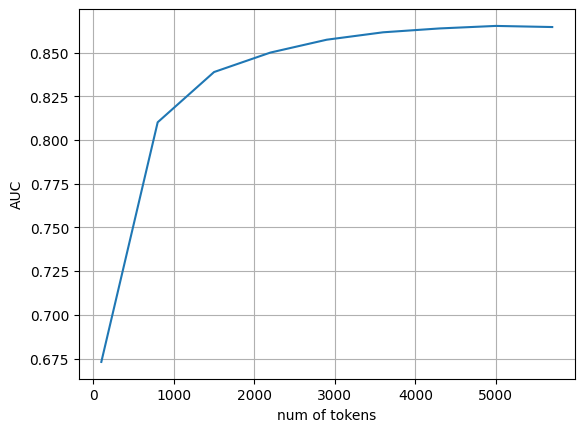

In [14]:
# do not change the code in the block below
# __________start of block__________
assert len(results) == len(vocab_sizes_list), "Check the code above"
assert min(results) >= 0.65, "Seems like the model is not trained well enough"
assert results[-1] > 0.84, "Best AUC ROC should not be lower than 0.84"

plt.plot(vocab_sizes_list, results)
plt.xlabel("num of tokens")
plt.ylabel("AUC")
plt.grid()

out_dict["bow_k_vary"] = results
# __________end of block__________

TF-iDF

In [15]:
k=min(10000, len(set(" ".join(texts_train).split())))

counts = Counter(" ".join(texts_train).split())

tf_idf_vocabulary = [key for key,val in counts.most_common(k)]

def texts_to_tf_idf(texts,idf=None):
  tf=[[0]*len(tf_idf_vocabulary) for _ in range (len(texts))]
  f=0
  if idf==None:
    f=1
    idf=[0]*len(tf_idf_vocabulary)
  tf_idf=[[0]*len(tf_idf_vocabulary) for _ in range (len(texts))]
  counts_local=[Counter(texts[i].split()) for i in range(len(texts))]
  for i in range(len(texts)):
    for j, token in enumerate(tf_idf_vocabulary):
      if token in counts_local[i]:
          tf[i][j] = counts_local[i][token]/len(texts[i].split())
          if f:
            idf[j]+=1
  if f:
    for j in range (len(tf_idf_vocabulary)):
      idf[j]=np.log(len(texts)/(idf[j]+1e-9))
  for i in range(len(texts)):
    for j in range(len(tf_idf_vocabulary)):
      tf_idf[i][j]=tf[i][j]*idf[j]
  tf_idf=np.array(tf_idf)
  norms = np.linalg.norm(tf_idf, axis=1, keepdims=True)
  norms[norms == 0] = 1.0
  tf_idf= tf_idf / norms
  return (tf_idf, idf)



In [16]:
X_train_tfidf,idf=texts_to_tf_idf(texts_train)
X_train_tfidf_torch= torch.tensor(X_train_tfidf,dtype=torch.float32)
X_test_tfidf=texts_to_tf_idf(texts_test,idf)[0]
X_test_tfidf_torch= torch.tensor(X_test_tfidf,dtype=torch.float32)

In [17]:
class my_tf_idf_model(nn.Module):
  def __init__(self, vector_size=k, h_l=32):
    super(my_tf_idf_model,self).__init__()
    self.fc1=nn.Linear(vector_size, h_l)
    self.fc2=nn.Linear(h_l,2)
    self.relu=nn.ReLU()

  def forward(self,x):
    return self.fc2(self.relu(self.fc1(x)))

In [18]:
model= my_tf_idf_model(k,h_l=32)

In [19]:
loss=nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

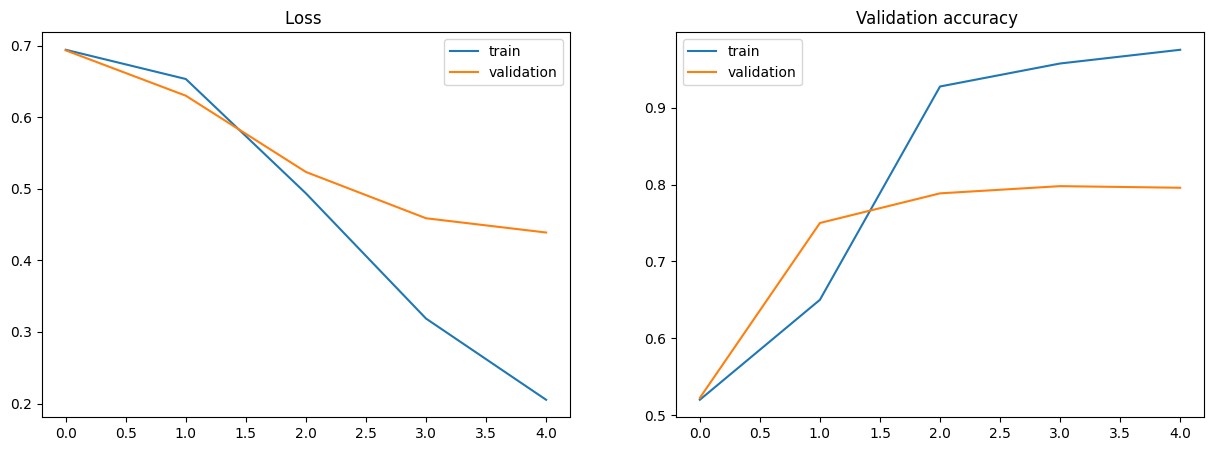

In [20]:
model_tf_idf = train_model(model, opt, X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch, n_iterations=201)

0.8782714017163342 0.8636402678551043


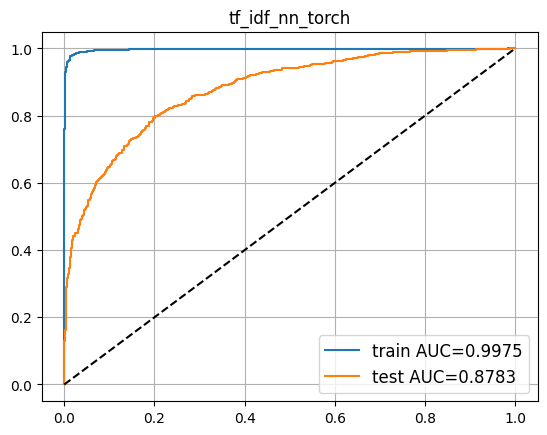

In [21]:
# do not change the code in the block below
# __________start of block__________
out_dict = visualize_and_save_results(
    model_tf_idf,
    "tf_idf_nn_torch",
    X_train_tfidf_torch,
    X_test_tfidf_torch,
    y_train,
    y_test,
    out_dict,
)
print(out_dict["tf_idf_nn_torch_test"],out_dict["bow_nn_torch_test"])
assert (
    out_dict["tf_idf_nn_torch_test"] >= out_dict["bow_nn_torch_test"]
), "AUC ROC on test data should be better or close to BoW for TF-iDF features"
# __________end of block__________

Для разных k

In [22]:
vocab_sizes_list = np.arange(100, 5800, 700)
results = []


for k in vocab_sizes_list:
  model=my_tf_idf_model(vector_size=k,h_l=32)

  # y_train_torch = torch.tensor(y_train,dtype=torch.long).to(device)
  # y_test_torch = torch.tensor(y_test,dtype=torch.long).to(device)
  #print(k,X_train_bow_torch.shape, y_train_torch.shape,y_test_torch.shape,X_test_bow_torch.shape )

  loss_function = nn.CrossEntropyLoss()
  opt = torch.optim.Adam(model.parameters(), lr=1e-3)
  tf_idf_nn_model = train_model(
    model,
    opt,
    X_train_tfidf_torch[:,:k],
    y_train_torch,
    X_test_tfidf_torch[:,:k],
    y_test_torch,
    n_iterations=101,
    show_plots=False
)
  with torch.no_grad():
      test_logits = tf_idf_nn_model(X_test_tfidf_torch[:,:k])
      # вероятность положительного класса (колонка 1)
      y_score = torch.softmax(test_logits, dim=1)[:, 1].cpu().numpy()

  auc = roc_auc_score(y_test, y_score)
  results.append(auc)

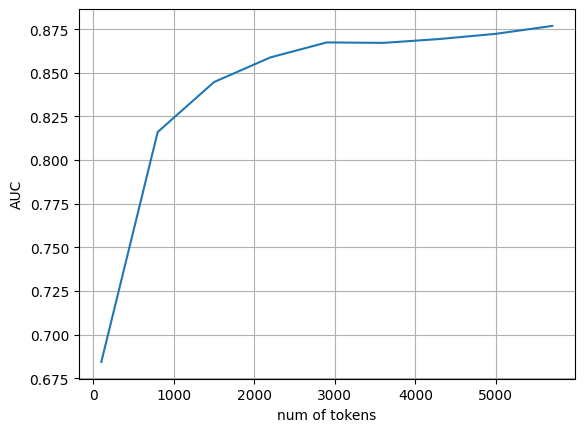

In [23]:
# do not change the code in the block below
# __________start of block__________
assert len(results) == len(vocab_sizes_list), "Check the code above"
assert min(results) >= 0.65, "Seems like the model is not trained well enough"
assert results[-1] > 0.85, "Best AUC ROC for TF-iDF should not be lower than 0.84"

plt.plot(vocab_sizes_list, results)
plt.xlabel("num of tokens")
plt.ylabel("AUC")
plt.grid()

out_dict["tf_idf_k_vary"] = results
# __________end of block__________

задача 3 - сравнение с наивным Байесовским классификатором

In [24]:
from sklearn.naive_bayes import MultinomialNB

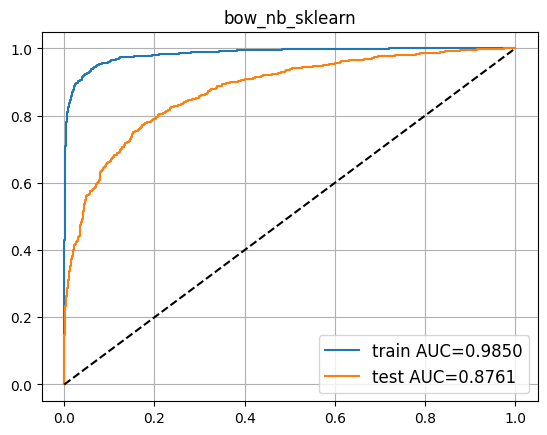

In [25]:
clf_nb_bow = MultinomialNB().fit(X=X_train_bow,y=y_train)

# do not change the code in the block below
# __________start of block__________
out_dict = visualize_and_save_results(clf_nb_bow, 'bow_nb_sklearn', X_train_bow, X_test_bow, y_train, y_test, out_dict)
# __________end of block__________

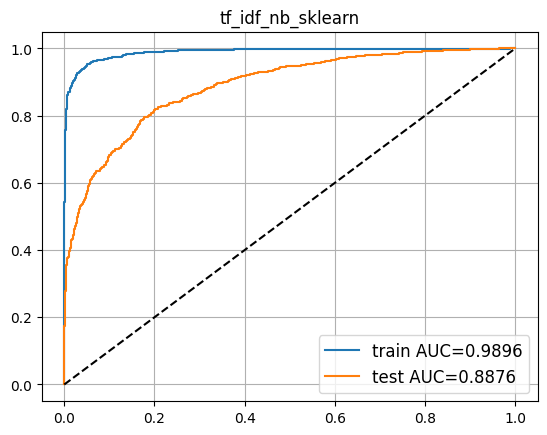

In [26]:
clf_nb_tfidf = MultinomialNB().fit(X_train_tfidf,y_train)

# do not change the code in the block below
# __________start of block__________
out_dict = visualize_and_save_results(clf_nb_tfidf, 'tf_idf_nb_sklearn', X_train_tfidf, X_test_tfidf, y_train, y_test, out_dict)
# __________end of block__________

In [27]:
# do not change the code in the block below
# __________start of block__________
assert (
    out_dict["tf_idf_nb_sklearn_test"] > out_dict["bow_nb_sklearn_test"]
), " TF-iDF results should be better"
assert (
    out_dict["tf_idf_nb_sklearn_test"] > 0.86
), "TF-iDF Naive Bayes score should be above 0.86"
# __________end of block__________

Теперь используем предобученные эмбеддинги

In [28]:
!pip install gensim

In [29]:
import gensim.downloader as api

In [30]:
gensim_embedding_model = api.load('fasttext-wiki-news-subwords-300')

# gensim_embedding_model.most_similar('россия')

[==================================================] 100.0% 958.5/958.4MB downloaded


In [31]:
gensim_embedding_model.most_similar('привет')

[('такой', 0.9356293678283691),
 ('всему', 0.9352875351905823),
 ('раздела', 0.9337158799171448),
 ('друго', 0.933343231678009),
 ('причина', 0.9326004385948181),
 ('також', 0.9325308799743652),
 ('удалить', 0.9322195649147034),
 ('словами', 0.9314824342727661),
 ('станет', 0.931201696395874),
 ('всем', 0.9310981631278992)]

In [32]:
def text_to_average_embedding(text, gensim_embedding_model):
    embedding_for_text=[]
    splits_text=text.split()
    for word in splits_text:
      if word in gensim_embedding_model:
        embedding_for_text.append(gensim_embedding_model[word])
        #print(1)


    return np.mean(np.array(embedding_for_text),axis=0)

In [33]:
X_train_emb = [
    text_to_average_embedding(text, gensim_embedding_model) for text in texts_train
]
X_test_emb = [
    text_to_average_embedding(text, gensim_embedding_model) for text in texts_test
]
assert (
    len(X_train_emb[0]) == gensim_embedding_model.vector_size
), "Seems like the embedding shape is wrong"

In [34]:
X_train_emb_torch=torch.tensor(X_train_emb,dtype=torch.float32)
X_test_emb_torch =torch.tensor(X_test_emb,dtype=torch.float32)

/tmp/ipython-input-1176356816.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  X_train_emb_torch=torch.tensor(X_train_emb,dtype=torch.float32)


In [35]:
X_train_emb_torch.shape

torch.Size([5000, 300])

In [36]:
class my_emb_model(nn.Module):
  def __init__(self,emb_l=300,h_l=32):
    super(my_emb_model,self).__init__()
    self.fc1=nn.Linear(emb_l,h_l)
    self.fc2=nn.Linear(h_l,2)
    self.relu=nn.ReLU()
  def forward(self,x):
    return self.fc2(self.relu(self.fc1(x)))

In [37]:
model=my_emb_model(h_l=32)

In [38]:
loss_function=nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(),lr=1e-3)


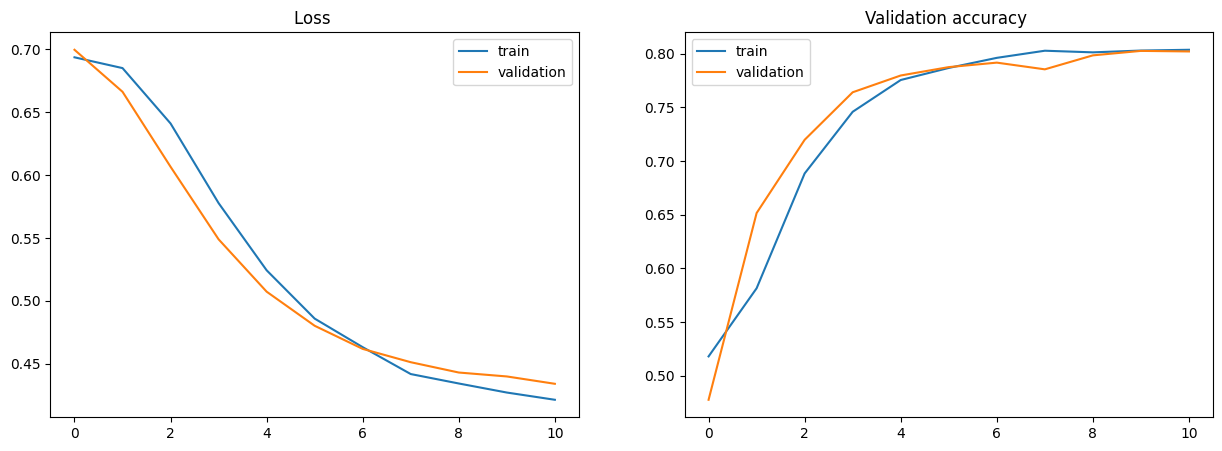

In [39]:
model = train_model(model, opt, X_train_emb_torch, y_train_torch, X_test_emb_torch, y_test_torch, n_iterations=501)

0.88338800392715 0.8961452747601166


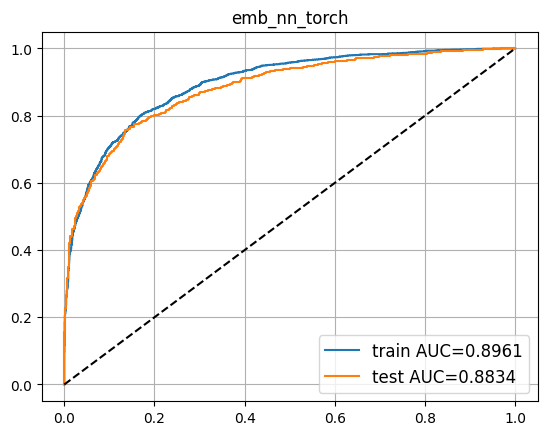

In [40]:
# do not change the code in the block below
# __________start of block__________

out_dict = visualize_and_save_results(
    model,
    "emb_nn_torch",
    X_train_emb_torch,
    X_test_emb_torch,
    y_train,
    y_test,
    out_dict,
)
print(out_dict["emb_nn_torch_test"],out_dict["emb_nn_torch_train"] )
assert (
    out_dict["emb_nn_torch_test"] > 0.87
), "AUC ROC on test data should be better than 0.86"
assert (
    out_dict["emb_nn_torch_train"] - out_dict["emb_nn_torch_test"] < 0.1
), "AUC ROC on test and train data should not be different more than by 0.1"
# __________end of block__________

In [41]:
# do not change the code in the block below
# __________start of block__________
FILENAME = "submission_dict_hw_text_classification.json"
with open(FILENAME, "w") as iofile:
    json.dump(out_dict, iofile)
print(f"File saved to `{FILENAME}`")
# __________end of block__________

File saved to `submission_dict_hw_text_classification.json`
